In [72]:
import numpy as np
import pandas as pd
import cv2
import os
import random

import matplotlib.pyplot as plt
import matplotlib.image as mpimg


import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms, utils
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim


import keras 
from keras.initializers import RandomNormal
from keras.layers import Dense, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dropout, BatchNormalization

import tensorflow as tf
from tensorflow.keras.optimizers import SGD
from keras.datasets import cifar10
from keras.utils.np_utils import to_categorical
from keras.models import Model
from keras.models import Sequential
from keras.callbacks import EarlyStopping

from tensorflow.keras import layers

import warnings
warnings.simplefilter("ignore", UserWarning)

## Load Data

In [24]:
## Set paths
img_folder = f'/{os.path.join("home","jovyan","my_work","QB","image", "images", "")}'
#img0 = "C:/Users/chach/OneDrive - HEC Paris/M2- Courses/16- Quantum Black/Quantum-Black-Challenge/data/ai_ready/images0/"
#img1 = "C:/Users/chach/OneDrive - HEC Paris/M2- Courses/16- Quantum Black/Quantum-Black-Challenge/data/ai_ready/images1/"
train_img = f'/{os.path.join("home","jovyan","my_work","QB","image", "train", "")}'
val_img = train_img = f'/{os.path.join("home","jovyan","my_work","QB","image", "val", "")}'
labels_image = pd.read_csv("x-ai_data.csv")

In [34]:
## Set paths
img_folder = "/home/jovyan/my_work/QB/image/images/"
train_img = "/home/jovyan/my_work/QB/image/train/"
val_img = "/home/jovyan/my_work/QB/image/val/"
labels_image = pd.read_csv("x-ai_data.csv")

## Create Subfolder

In [36]:
train = labels_image.loc[labels_image['split']=='train']
val = labels_image.loc[labels_image['split']=='validation']

In [37]:
train0 = train.loc[train['class']==0]
train1 = train.loc[train['class']==1]

val0 = val.loc[val['class']==0]
val1 = val.loc[val['class']==1]


In [38]:
train0.index

Int64Index([  1,   2,   4,   5,   7,   9,  10,  12,  17,  18,
            ...
            984, 986, 987, 988, 989, 990, 991, 994, 995, 996],
           dtype='int64', length=692)

In [41]:
#Move TRAIN images labeled 0 to the correct folder

for i in train0.index:
    im = cv2.imread(img_folder+train0.loc[i,'filename'])
    cv2.imwrite(train_img + '0/' +train0.loc[i,'filename'], im)
#Move TRAIN images labeled 1 to the correct folder
for i in train1.index:
    im = cv2.imread(img_folder+train1.loc[i,'filename'])
    cv2.imwrite(train_img+'1/' +train1.loc[i,'filename'], im)

In [40]:
#Move val images labeled 0 to the correct folder
for i in val0.index:
    im = cv2.imread(img_folder+val0.loc[i,'filename'])
    cv2.imwrite(val_img + '0/' +val0.loc[i,'filename'], im)
#Move val images labeled 1 to the correct folder
for i in val1.index:
    im = cv2.imread(img_folder+val1.loc[i,'filename'])
    cv2.imwrite(val_img+'1/' +val1.loc[i,'filename'], im)

## Model

In [63]:
 import shutil

#Remove hidden file
shutil.rmtree("image/train/.ipynb_checkpoints")
shutil.rmtree("image/val/.ipynb_checkpoints")

In [64]:
image_size = (256, 256)
batch_size = 256

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_img,
    validation_split=0,
    seed=123,
    image_size=image_size,
    batch_size=batch_size,
)

Found 1399 files belonging to 2 classes.


In [65]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    val_img,
    validation_split=0,
    seed=123,
    image_size=image_size,
    batch_size=batch_size,
)

Found 400 files belonging to 2 classes.


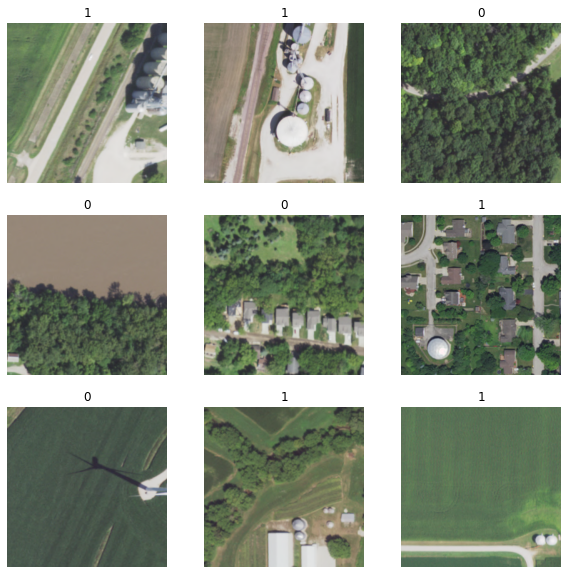

In [66]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [67]:
def create_data_augmentation_model():
    """
    function to create the keras data_augmentation layer
    args:
        - none
    returns:
        - data_augementation : keras layer, used in the make_model function
    """
    data_augmentation = keras.Sequential(
        [
            layers.RandomFlip("horizontal"),
            layers.RandomRotation(0.1),
        ]
    )
    return data_augmentation

In [73]:
def make_model(input_shape: tuple, num_classes: int):
    """
    function building a keras deep learning model with data augmentation for image recognition
    args:
        - input_shape : tuple containing the dimensions of the pictures. e.g input_shape = (180,180) when our input image is of shape 180*180
        - num_classes : int, number of different classes
    returns:
        - cnn_model : keras model with data augmentation and
    """
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    data_augmentation = create_data_augmentation_model()
    x = data_augmentation(inputs)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    cnn_model = keras.Model(inputs, outputs)
    return cnn_model

In [74]:
model = make_model(input_shape=image_size + (3,), num_classes=2)

In [75]:
epochs = 25

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/25
6/6 [==============================] - ETA: 0s - loss: 0.9708 - accuracy: 0.6126

/opt/conda/lib/python3.8/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


6/6 [==============================] - 15s 2s/step - loss: 0.9708 - accuracy: 0.6126 - val_loss: 0.6931 - val_accuracy: 0.4850
Epoch 2/25
6/6 [==============================] - 14s 2s/step - loss: 0.6087 - accuracy: 0.6962 - val_loss: 0.6928 - val_accuracy: 0.5150
Epoch 3/25
6/6 [==============================] - 13s 2s/step - loss: 0.4840 - accuracy: 0.7748 - val_loss: 0.6926 - val_accuracy: 0.5150
Epoch 4/25
6/6 [==============================] - 13s 2s/step - loss: 0.4024 - accuracy: 0.8256 - val_loss: 0.6926 - val_accuracy: 0.5150
Epoch 5/25
6/6 [==============================] - 13s 2s/step - loss: 0.3727 - accuracy: 0.8377 - val_loss: 0.6926 - val_accuracy: 0.5150
Epoch 6/25
6/6 [==============================] - 13s 2s/step - loss: 0.3601 - accuracy: 0.8620 - val_loss: 0.6926 - val_accuracy: 0.5150
Epoch 7/25
6/6 [==============================] - 13s 2s/step - loss: 0.3179 - accuracy: 0.8706 - val_loss: 0.6928 - val_accuracy: 0.5150
Epoch 8/25
6/6 [=============================